In [1]:
import nibabel as nib
import numpy as np
from model.utils import *
from model.helper import generate_grids, get_basis, scale
import torch
from sklearn.gaussian_process.kernels import RBF, Matern
import matplotlib.pyplot as plt
import model.SIMBA_VI as SIMBA_VI
import model.SIMBA_Gibbs as SIMBA_Gibbs
import pandas as pd
import nibabel as nib
import nilearn.plotting as plotting
import hcp_utils as hcp

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
path = f"data/abcd"

time = "baseline"
hemi='left'

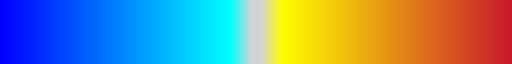

In [3]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["blue","cyan","lightgray","lightgray","yellow","#C9182B"]
values = np.array([0, 0.45, 0.49, 0.51, 0.55, 1])
cmap = LinearSegmentedColormap.from_list("gangchen", list(zip(values, colors)))
cmap

In [ ]:
covariates = pd.read_csv(f'{path}/{time}_covariates.tsv', sep='\t', header=0)
covariates["site"] = np.where(covariates["site"] == 22, 1, covariates["site"])
site_ids = np.sort(covariates["site"].unique())
X = covariates.values
X[:,:3] = (X[:,:3] - X[:,:3].mean(axis=0)) /  X[:,:3].std(axis=0)

In [5]:
n_site = len(site_ids)
n_site

21

In [6]:
Y = pd.read_csv(f'{path}/{time}_{hemi}_values.csv',header=None)
Y = Y.values

In [7]:
S = pd.read_csv(f'{path}/{hemi}_grids.csv')
S = scale(S).values

In [8]:
from sklearn.gaussian_process.kernels import RBF, Matern
### specify kernel function
ls = 0.1
kernel = Matern(length_scale=ls, nu=1.5)

In [9]:
# full_cov = kernel(S[:10000],S[:10000])
# U,lamb_sqrt,_ = np.linalg.svd(full_cov)

# cumsum = np.cumsum(lamb_sqrt, axis=0)
# total = np.sum(lamb_sqrt)
# lower = np.nonzero(cumsum >= 0.8 * total)[0][0]
# upper = np.nonzero(cumsum >= 0.98 * total)[0][0]
# L_list = np.linspace(lower, upper,num=5, dtype=int)
# L_list #array([ 224,  471,  719,  967, 1214, 1462, 1710, 1957, 2205, 2453])


In [10]:
# del full_cov, U, lamb_sqrt

In [11]:
dtype = torch.float32
S = torch.from_numpy(S).to(dtype)
Y = torch.from_numpy(Y).to(dtype)
X = torch.from_numpy(X).to(dtype)

In [12]:
site = [X[:,4]==i for i in range(21)]

In [13]:
Y_site_list=[]
X_site_list=[]
for id in site_ids:
    # leave one site out
    Y_site = Y[X[:,-1] == id]
    X_site = X[X[:,-1] == id]
    X_site = X_site[:,:-1]
    Y_site_list.append(Y_site)
    X_site_list.append(X_site)

In [14]:
site_data=[]
siteloo_data=[]
for id in site_ids:
    # leave one site out
    Y_site = Y_site_list[id-1]
    X_site = X_site_list[id-1]

    Y_loo = torch.cat(Y_site_list[:id-1] + Y_site_list[id:])
    X_loo = torch.cat(X_site_list[:id-1] + X_site_list[id:])

    site_data.append({'X': X_site,
            'Y': Y_site})
    siteloo_data.append({'X': X_loo,
            'Y': Y_loo})

In [15]:
X = X[:,:4]
X

tensor([[ 0.1889, -0.5257, 10.8333,  1.0000],
        [ 0.9555,  1.1416,  9.3333,  0.0000],
        [ 0.1453,  0.5156, 10.2500,  0.0000],
        ...,
        [ 0.8114, -0.1224, 10.3333,  1.0000],
        [ 0.0753, -0.0733,  9.0000,  0.0000],
        [ 0.8718, -0.1032, 10.9167,  0.0000]])

In [17]:
# N, V = Y.shape
# n_ind = torch.arange(0,N)
# vi_results = []
# for L in L_list:
#     print(L)
#     L_eta = int(0.1*L)
#     mse = []
#     mae = []
#     for site in range(n_site):
#         X_train = site_data[site]['X']
#         Y_train = site_data[site]['Y']
#         X_train = torch.column_stack((torch.ones(X_train.shape[0]), X_train))
#         X_test = siteloo_data[site]['X']
#         Y_test = siteloo_data[site]['Y']
#         X_test = torch.column_stack((torch.ones(X_test.shape[0]), X_test))
    
#         model = SIMBA_VI.SIMBA_VI(Y=Y_train, X= X_train, grids=S,
#                                  kernel = kernel, L = L, L_eta = L_eta, 
#                                  verbose=-1, include_intercept=True)
#         paras, profile = model.run(verbose=False)

#         Y_pred =  (X_test @ paras['E_alpha'])[:,None] + X_test@(paras['E_theta_beta'] @ model.basis.t())
#         mse.append(((Y_pred - Y_test) ** 2).mean())
#         mae.append((Y_pred - Y_test).abs().mean())
#         del model
#     vi_results.append({'L': L, 'MSE': np.round(np.mean(mse),2)})

In [18]:
#vi_results
#[{'L': 186, 'MSE': 4.52},
#  {'L': 430, 'MSE': 4.41},
#  {'L': 675, 'MSE': 4.39},
#  {'L': 919, 'MSE': 4.4},
#  {'L': 1164, 'MSE': 4.4}]

In [16]:
L = 675
L_eta = int(0.1*L)

In [17]:
import model.SIMBA_VI as SIMBA_VI
import importlib
SIMBA_VI = importlib.reload(SIMBA_VI) 

In [ ]:

model = SIMBA_VI.SIMBA_VI(Y=Y, X= X, grids=S,
                        kernel = kernel, L = L, L_eta = L_eta, 
                        verbose=-1, include_intercept=True)
paras, profile = model.run(verbose=False)
voxel_mcmc = model.post_samples(n_mcmc=1000)

In [19]:
pp = (((( voxel_mcmc > 0) * 1.0).mean(dim=(0))) - 0.5) * 2
voxel_select = (pp.abs() > 0.99) * 1
voxel_est= voxel_mcmc.reshape(-1, model.J, model.V).mean(dim=0)
main_eff = voxel_est * voxel_select

#### Visaulization

/var/folders/_5/n4pn07p954s_9x6bwyrrptq40000gn/T/ipykernel_3581/1897316350.py:12: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  fig = plotting.plot_surf_stat_map(


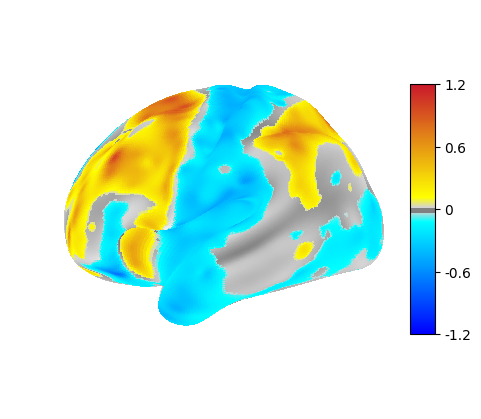

In [20]:
template_file = f'{path}/NDARINV0A4ZDYNL_zstat11.dtseries.nii'
img = nib.load(template_file)
x = img.get_fdata()
x[0,:]=np.nan
if hemi == "left":
    x[0,hcp.struct.cortex_left] = main_eff[1]
else:
    x[0,hcp.struct.cortex_right] = main_eff[1]
x_abs = np.abs(x[hcp.struct.cortex])
x_abs_min = x_abs[x_abs > 0].min()
x_abs_max = x_abs[x_abs > 0].max()
fig = plotting.plot_surf_stat_map(
                hcp.mesh.inflated, hcp.cortex_data(x[0]),
                bg_map=hcp.mesh.sulc,cmap=cmap,
                threshold=x_abs_min,colorbar=True,
                vmax=1.2,vmin=-1.2 ,
                hemi=hemi)
#fig.savefig(f'plots/abcd/{time}_{hemi}_SIMBA_VI_cog_allsite_mean.png', dpi=300)

#### PPC curves

In [21]:
ppc = model.PPC(n_mcmc=30, dtype=torch.float16)

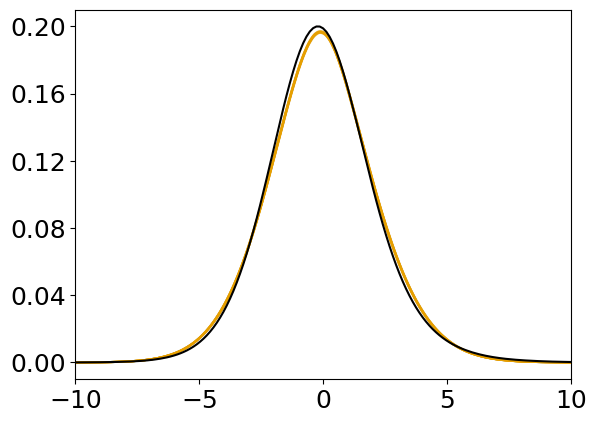

In [23]:
from fastkde import fastKDE
## takes about 3 mins for 100 draws

for i in range(ppc.shape[0]):
    density = fastKDE.pdf(ppc[i].reshape(-1),ecf_precision=1) # flat to vector
    density.plot(alpha=0.2, color="#E69F00", label='Posterior predictive' if i == 0 else None)
data_den= fastKDE.pdf(Y.reshape(-1),ecf_precision=1)
data_den.plot(alpha=1.0, color="black", label='Observed data')
plt.xlim(-10, 10)  
plt.ylabel('')
plt.xlabel('')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

plt.xticks(np.linspace(-10, 10, 5), fontsize=18)
plt.yticks(np.linspace(0, 0.2, 6),fontsize=18)
# Add legend (only one entry for grey lines)
# plt.legend(
#     loc='upper center',
#     fontsize=12,
#     bbox_to_anchor=(0.5, 1.15),  # center above axes
#     ncol=2,                      # number of legend columns
#     frameon=False                # no border
# )

plt.savefig(f'plot/SIMBA_VI_ppc_J{L}_Jeta{L_eta}.png', dpi=300, bbox_inches='tight')  
plt.show()

In [18]:
import model.SIMBA_Gibbs as SIMBA_Gibbs
model = SIMBA_Gibbs.SIMBA_Gibbs( Y=Y,
    grids=S, kernel=kernel, X = X,include_intercept=True,
    L = L, L_eta = L_eta,
    burnin=2000,
    mcmc_sample=1000,
    thin=1,
    dtype=dtype)
samples = model.run(n_chains=1, parallel = False)

100%|██████████| 3000/3000 [12:27<00:00,  4.01it/s]

Chain 1 finished in 747.76 seconds


In [19]:
voxel_mcmc = samples['alpha'][:,:,:,None] + samples['theta_beta'] @ model.basis.t()
pp = (((( voxel_mcmc > 0) * 1.0).mean(dim=(0,1))) - 0.5) * 2
voxel_select = (pp.abs() > 0.99) * 1
voxel_est= voxel_mcmc.reshape(-1, model.J, model.V).mean(dim=0)
main_eff = voxel_est * voxel_select

/var/folders/_5/n4pn07p954s_9x6bwyrrptq40000gn/T/ipykernel_6805/1969399963.py:12: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  fig = plotting.plot_surf_stat_map(


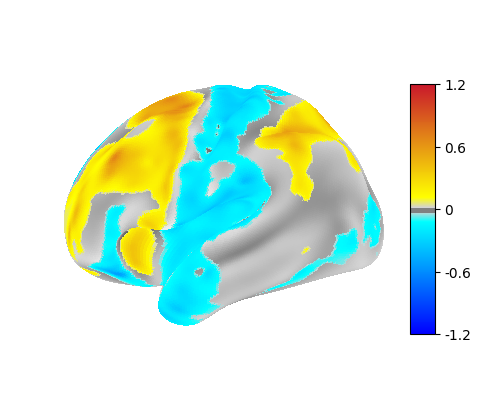

In [20]:
template_file = f'{path}/NDARINV0A4ZDYNL_zstat11.dtseries.nii'
img = nib.load(template_file)
x = img.get_fdata()
x[0,:]=np.nan
if hemi == "left":
    x[0,hcp.struct.cortex_left] = main_eff[1]
else:
    x[0,hcp.struct.cortex_right] = main_eff[1]
x_abs = np.abs(x[hcp.struct.cortex])
x_abs_min = x_abs[x_abs > 0].min()
x_abs_max = x_abs[x_abs > 0].max()
fig = plotting.plot_surf_stat_map(
                hcp.mesh.inflated, hcp.cortex_data(x[0]),
                bg_map=hcp.mesh.sulc,cmap=cmap,
                threshold=x_abs_min,colorbar=True,
                vmax=1.2,  vmin=-1.2, 
                hemi=hemi)
#fig.savefig(f'plots/{time}_{hemi}_Gibbs_mean.png', dpi=300)

In [21]:
ppc = model.PPC(n_samples=30, dtype=torch.float16)

In [ ]:
from fastkde import fastKDE
for i in range(ppc.shape[0]):
    density = fastKDE.pdf(ppc[i].reshape(-1).to(torch.float16),ecf_precision=1) # flat to vector
    density.plot(alpha=0.2, color="#E69F00", label='Posterior predictive' if i == 0 else None)
data_den= fastKDE.pdf(Y.reshape(-1).to(torch.float16),ecf_precision=1)
data_den.plot(alpha=1.0, color="black", label='Observed data')
plt.xlim(-10, 10)  
plt.ylabel('')
plt.xlabel('')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

plt.xticks(np.linspace(-10, 10, 5), fontsize=18)
plt.yticks(np.linspace(0, 0.2, 6),fontsize=18)
# Add legend (only one entry for grey lines)
# plt.legend(
#     loc='upper center',
#     fontsize=12,
#     bbox_to_anchor=(0.5, 1.15),  # center above axes
#     ncol=2,                      # number of legend columns
#     frameon=False                # no border
# )

plt.savefig(f'plot/abcd/SIMBA_Gibbs_ppc.png', dpi=300, bbox_inches='tight')  
plt.show()